# Recurrent Neural Networks

```{epigraph}
The nervous system contains many circular paths, whose activity so regenerates the excitation of any participant neuron that reference to time past becomes indefinite, although it still implies that afferent activity has realized one of a certain class of configurations over time. Precise specification of these implications by means of recursive functions, and determination of those that can be embodied in the activity of nervous nets, completes the theory.

-- Warren McCulloch and Walter Pitts, 1943
```

A recurrent neural network (RNN) is a type of artificial neural network that uses sequential data or time series data and it is mainly used for Natural Language Processing. Now let us see what it looks like.

Sequential data is not [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables).

:::{figure-md} sequential data
<img src="../../images/deep-learning/RNN/sequential_data.png" width="90%" class="bg-white mb-1">

sequential data
:::

And the RNNs use recurrent edge to update.

:::{figure-md} rnn1
<img src="../../images/deep-learning/RNN/rnn1.png" width="90%" class="bg-white mb-1">

RNN1
:::

If unroll over a sequence $(x_0,x_1,x_2)$.

:::{figure-md} rnn2
<img src="../../images/deep-learning/RNN/rnn2.png" width="90%" class="bg-white mb-1">

RNN2
:::

Then, the input (w0,w1,...,wt) sequence of words ( 1-hot encoded ) and the output (w1,w2,...,wt+1) shifted sequence of words ( 1-hot encoded ) have the following relation.

:::{figure-md} rnn3
<img src="../../images/deep-learning/RNN/rnn3.png" width="90%" class="bg-white mb-1">

RNN3
:::

The input projection is $x_t = Emb(\omega_t) = E\omega_t$, the recurrent connection is $h_t = g(W^h h_t + x_t + b^h)$, and the output projection should be $y = softmax(W^o h_t + b^o)$.
The backpropagation of RNN is in this way:

:::{figure-md} rnn4
<img src="../../images/deep-learning/RNN/rnn4.png" width="90%" class="bg-white mb-1">

RNN4
:::

Let's make the backpropagation process more clearly.

First, we unfold a single-hidden layer RNN, and we can see the weight matrices $W_h$ in it.

:::{figure-md} backpropagation
<img src="../../images/deep-learning/RNN/bp_rnn1.png" width="90%" class="bg-white mb-1">

backpropagation for RNN
:::

Through the image, we can get the output:

- Net input: $z_h^{<t>} = W_hx x^{<t>} + W_hh h^{<t-1>} + b_h$
- Activation: $h^{<t>} = \sigma (z_h^{<t>})$
- Output: $z_y^<t> = W_yh h^{<t>} + b_y$, $y^{<t>} = \sigma(z_y^{<t>})$

After that, the loss is computed as the sum over all time steps: $L = \sum_{t=1}^T L^{<t>}$

```{note}
There are some key points:

- Similar as training very deep networks with tied parameters.
- Example between $x_0$ and $y_2$: Wh is used twice.
- Usually truncate the backprop after $T$ timesteps.
- Difficulties to train long-term dependencies.
```

### Code

In [56]:
# A text classifier implemented in TensorFlow to classify SMS spam messages.

# Code first downloads and processes the SMS Spam Collection dataset from the UCI Machine Learning Repository and then builds a basic Recurrent neural network (RNN) for text classification using TensorFlow.

# The code first cleans and preprocesses the text, then splits it into training and test sets, followed by tokenizing and padding the training set. Next, the code uses an embedding layer to convert the tokenized text into a vector representation, which is then fed into a recurrent neural network and finally classified using a Softmax loss function.

#The output of the # code is the accuracy of the classifier along with some statistics

In [57]:
# We implement an RNN in TensorFlow to predict spam/ham from texts

import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops
tf.disable_v2_behavior()
ops.reset_default_graph()

In [58]:
# Start a graph
sess = tf.Session()

In [59]:
# epochs: the number of times the model will iterate through the entire dataset during training.
# batch_size: the number of samples used for each training step.
# max_sequence_length: the maximum length of a sequence in the training data. Sequences that exceed this length will be truncated, while sequences that are shorter will be padded with zeros.
# rnn_size: the number of neurons in the hidden layer of the RNN.
# embedding_size: the dimensionality of the word embeddings. Word embeddings are a technique for representing each word as a low-dimensional vector, which can effectively capture the semantic information of the word.
# min_word_frequency: words with a frequency lower than this value will be filtered out and not used for training.
# learning_rate: the learning rate of the model, which controls the step size at which the model updates its parameters during each iteration.
# dropout_keep_prob: the probability of keeping a neuron active during training using Dropout. It is a placeholder, which will be assigned a specific value during model training.

In [60]:
# Set RNN parameters
epochs = 20
batch_size = 250
max_sequence_length =25 
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32,name='dropout_keep_prob')

In [61]:
# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]


In [62]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string

In [63]:
# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]
#print(text_data[:5])
print(text_data_train[:5])

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat', 'ok lar joking wif u oni', 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs', 'u dun say so early hor u c already then say', 'nah i dont think he goes to usf he lives around here though']


In [64]:
# Tokenize and pad sequences
vocab_processor = tf.keras.preprocessing.text.Tokenizer()
vocab_processor.fit_on_texts(text_data_train)
text_processed = vocab_processor.texts_to_sequences(text_data_train)
max_document_length = max([len(x) for x in text_processed])
#pads the text data to ensure all sequences have the same length (max_sequence_length).
text_processed = tf.keras.preprocessing.sequence.pad_sequences(text_processed, maxlen=max_sequence_length, padding='post')
print(text_processed.shape)
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

(5574, 25)


In [65]:
# Shuffle and split data
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
print(text_processed)
y_shuffled = text_data_target[shuffled_ix]

[[  44  440 3985 ...    0    0    0]
 [  46  309 1358 ...    0    0    0]
 [  47  459    9 ... 2713  367 2714]
 ...
 [8626   59    9 ...    0    0    0]
 [ 500  108  105 ...  198   12   47]
 [2428   40  471 ...    0    0    0]]


In [66]:
# Split train/test set
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
print(x_train)
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.word_counts)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

[[   3  146    1 ...    0    0    0]
 [ 831   23   51 ...    0    0    0]
 [ 421  218    3 ...  794 4603    0]
 ...
 [1660    6  716 ...    0    0    0]
 [  34    3   28 ...    0    0    0]
 [2008  157 3290 ...  221 3298  634]]
Vocabulary Size: 8629
80-20 Train Test split: 4459 -- 1115


In [67]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [68]:
# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size+1, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [69]:
# Define the RNN cell
# tensorflow change >= 1.0, rnn is put into tensorflow.contrib directory. Prior version not test.
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

Tensor("dropout/SelectV2:0", shape=(?, 25, 10), dtype=float32)


C:\Users\14471\AppData\Local\Temp\ipykernel_19288\3567858806.py:3: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)


In [70]:
# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

In [71]:
# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)
print(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))
print(accuracy)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [72]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Start training
for epoch in range(epochs):
    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        max_len = max([len(x) for x in x_train_batch])
        x_train_batch = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in x_train_batch])
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
    # Run loss and accuracy for training
    train_dict = {x_data: x_train, y_output: y_train, dropout_keep_prob:1.0}
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))
    

Epoch: 1, Test Loss: 0.63, Test Acc: 0.92
Epoch: 2, Test Loss: 0.58, Test Acc: 0.93
Epoch: 3, Test Loss: 0.51, Test Acc: 0.93
Epoch: 4, Test Loss: 0.43, Test Acc: 0.94
Epoch: 5, Test Loss: 0.36, Test Acc: 0.94
Epoch: 6, Test Loss: 0.3, Test Acc: 0.94
Epoch: 7, Test Loss: 0.26, Test Acc: 0.94
Epoch: 8, Test Loss: 0.22, Test Acc: 0.95
Epoch: 9, Test Loss: 0.19, Test Acc: 0.95
Epoch: 10, Test Loss: 0.17, Test Acc: 0.96
Epoch: 11, Test Loss: 0.14, Test Acc: 0.97
Epoch: 12, Test Loss: 0.12, Test Acc: 0.97
Epoch: 13, Test Loss: 0.099, Test Acc: 0.99
Epoch: 14, Test Loss: 0.078, Test Acc: 1.0
Epoch: 15, Test Loss: 0.06, Test Acc: 1.0
Epoch: 16, Test Loss: 0.045, Test Acc: 1.0
Epoch: 17, Test Loss: 0.035, Test Acc: 1.0
Epoch: 18, Test Loss: 0.027, Test Acc: 1.0
Epoch: 19, Test Loss: 0.022, Test Acc: 1.0
Epoch: 20, Test Loss: 0.017, Test Acc: 1.0


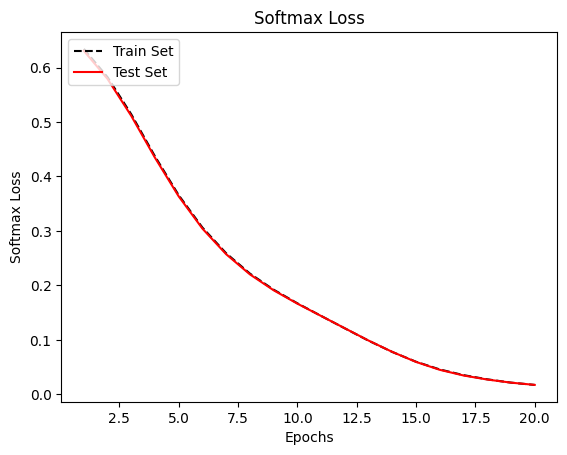

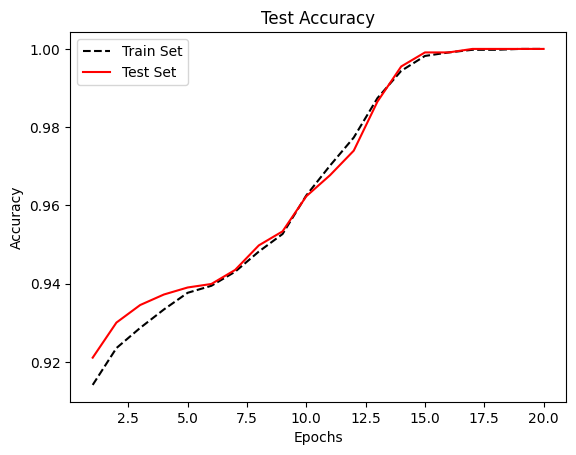

In [73]:
# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

## Your turn! 🚀

Practice the Recurrent Neural Networks by following this TBD.

## Self study

TBD

## Acknowledgments

Thanks to [Nick](https://github.com/nfmcclure) for creating the open-source course [tensorflow_cookbook](https://github.com/nfmcclure/tensorflow_cookbook) and [Sebastian Raschka](https://github.com/rasbt) for creating the open-sourse [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20). It inspires the majority of the content in this chapter.

---

```{bibliography}
:filter: docname in docnames
```